In [1]:
import os
import sys

if "ORIGINAL_WORKING_DIRECTORY" not in globals():
    ORIGINAL_WORKING_DIRECTORY = os.getcwd()

current_directory = os.getcwd()
parent_directory = os.path.dirname(current_directory)
os.chdir(parent_directory)
sys.path.insert(0, os.getcwd())

In [2]:
import pandas as pd
from pandasql import sqldf
from modules.data_processing.data_processor import ExperimentProcessor

In [3]:
data = pd.read_csv('./data/raw_data/experiments_dataset.csv')
processor = ExperimentProcessor(data)

In [4]:
experiments_df = processor.get_experimets_data()
experiments_df["timestamp"] = pd.to_datetime(experiments_df["timestamp"])
experiments_df.head()

,event_name,item_id,timestamp,experiment_name,variant_id,user_id
0,SEARCH,NaN,2021-08-02 23:55:38.966000-04:00,searchbackend/recommended-products,6157,3204901
1,SEARCH,NaN,2021-08-02 23:55:38.966000-04:00,mclics/ads-adsearch-boost-incremental-desktop-mla,3809,3204901
2,SEARCH,NaN,2021-08-02 23:55:38.966000-04:00,searchbackend/cbt-antiboost,6333,3204901
3,SEARCH,NaN,2021-08-02 23:55:38.966000-04:00,search/back-filters,5059,3204901
4,SEARCH,NaN,2021-08-02 23:55:38.966000-04:00,filters/sort-by-ranking,7057,3204901


In [6]:
purchases = processor.get_purchases_data()
purchases["timestamp"] = pd.to_datetime(purchases["timestamp"])
purchases.head()

,event_name,item_id,timestamp,site,experiments,user_id
204,BUY,740440936.0,2021-08-02 23:53:46.363000-04:00,MLA,"{buyingflow/user-track=6796, buyingflow/addres...",426144
295,BUY,680029039.0,2021-08-02 23:38:37.024000-04:00,MLA,"{buyingflow/user-track=6796, buyingflow/addres...",6498883
305,BUY,988145209.0,2021-08-02 23:41:31.971000-04:00,MLA,"{buyingflow/user-track=6796, buyingflow/addres...",6498883
447,BUY,885565729.0,2021-08-02 23:11:25.388000-04:00,MLA,"{buyingflow/user-track=6796, buyingflow/addres...",2866832
562,BUY,934373429.0,2021-08-02 20:01:39.802000-04:00,MLA,"{buyingflow/user-track=6796, buyingflow/addres...",411939


## Analysis

In [7]:
query = """
SELECT
    experiments_df.*,
    purchases.item_id AS purchase_item_id,
    purchases.timestamp AS purchase_timestamp
FROM experiments_df
LEFT JOIN purchases
    ON (experiments_df.item_id = purchases.item_id
        AND experiments_df.user_id = purchases.user_id
        AND experiments_df.timestamp <= purchases.timestamp
        AND DATE(experiments_df.timestamp) = DATE(purchases.timestamp))
    OR (experiments_df.event_name = 'SEARCH'
        AND experiments_df.user_id = purchases.user_id
        AND experiments_df.timestamp <= purchases.timestamp
        AND DATE(experiments_df.timestamp) = DATE(purchases.timestamp)
    )
"""

result = sqldf(query, globals())

In [8]:
result.head()

,event_name,item_id,timestamp,experiment_name,variant_id,user_id,purchase_item_id,purchase_timestamp
0,SEARCH,NaN,2021-08-02 23:55:38.966000,searchbackend/recommended-products,6157,3204901,NaN,None
1,SEARCH,NaN,2021-08-02 23:55:38.966000,mclics/ads-adsearch-boost-incremental-desktop-mla,3809,3204901,NaN,None
2,SEARCH,NaN,2021-08-02 23:55:38.966000,searchbackend/cbt-antiboost,6333,3204901,NaN,None
3,SEARCH,NaN,2021-08-02 23:55:38.966000,search/back-filters,5059,3204901,NaN,None
4,SEARCH,NaN,2021-08-02 23:55:38.966000,filters/sort-by-ranking,7057,3204901,NaN,None


In [9]:
result1 = result.copy()
result = result[~result["purchase_timestamp"].isna()]

In [10]:
result["time_diff"] = pd.to_datetime(result["purchase_timestamp"]) - pd.to_datetime(result["timestamp"])
result["time_diff"] = result["time_diff"].dt.total_seconds() / 60

result1["time_diff"] = pd.to_datetime(result1["purchase_timestamp"]) - pd.to_datetime(result1["timestamp"])
result1["time_diff"] = result1["time_diff"].dt.total_seconds() / 60

In [11]:
result = result.sort_values(by=["timestamp", "purchase_timestamp"])
result1 = result1.sort_values(by=["timestamp","purchase_timestamp"])

In [12]:
result.drop_duplicates(
    subset=["event_name", "item_id", "experiment_name", "variant_id", "user_id"],
    keep="first",
    inplace=True
)

result1.drop_duplicates(
    subset=["event_name", "item_id", "experiment_name", "variant_id", "user_id"],
    keep="first",
    inplace=True
)

#### Descriptive time differences

In [13]:
grouped_stats = result.groupby(['event_name'])['time_diff'].describe()
grouped_stats

,count,mean,std,min,25%,50%,75%,max
event_name,,,,,,,,
CHECKOUT_1,1721.0,8.153519,42.870803,0.253867,0.797933,1.439817,3.109483,728.018500
CHECKOUT_2,1722.0,4.006367,22.772206,0.156983,0.522617,0.900767,1.919383,378.407017
CHECKOUT_3,1868.0,0.719245,2.632875,0.094533,0.210133,0.301700,0.479517,47.926783
PRODUCT,5654.0,36.698056,100.129710,0.450850,2.318917,5.648067,19.489467,1013.408683
SEARCH,9583.0,91.983601,158.065206,0.152333,7.065608,20.524650,90.607117,1099.509317


In [14]:
grouped_stats = result.groupby(["event_name","experiment_name"])['time_diff'].describe()
grouped_stats

count  \
event_name experiment_name                                            
CHECKOUT_1 buyingflow/escWebMLA                               854.0   
           buyingflow/user-track                              867.0   
CHECKOUT_2 buyingflow/address_hub                             795.0   
           buyingflow/user-track                              927.0   
CHECKOUT_3 buyingflow/address_hub                             934.0   
           buyingflow/user-track                              934.0   
PRODUCT    cookiesConsentBanner                               774.0   
           mshops/HideTransitionModal                           2.0   
           pdp/cpgShowOnlyAddToCart                             3.0   
           pdp/viewItemPageMigrationDesktopReviewsNoTabs      404.0   
           pdp/viewItemPageMigrationReturns                   536.0   
           qadb/sa-on-vip                                     109.0   
           search/remove-ecn-tag                              647.0   
           search/tendency-landing-enabled-MLA                228.0   
           vip/carousel-v2p-above-the-fold                    700.0   
           vip/seller-with-tooltip                            760.0   
           vip/shippingCalculatorMigrationModalExperiment     717.0   
           vip/showV2V3BoxMessages                            774.0   
SEARCH     cookiesConsentBanner                               575.0   
           filters/sort-by-ranking                            594.0   
           frontend/assetsCdnDomainMLA                        573.0   
           frontend/assetsCdnDomainMLU                        573.0   
           mclics/ads-adsearch-boost-incremental-desktop-mla  470.0   
           mclics/search-list-algorithms                      449.0   
           mclics/search-pads-none-desktop-mla                459.0   
           mclics/show-pads-global                            470.0   
           mclics/show-pads-search-list                       459.0   
           search/back-filters                                573.0   
           search/best-seller-aa-testing-fail-fast-edition    542.0   
           search/best-seller-fail-fast-edition-MLA           530.0   
           search/checkOnBehavior                              26.0   
           search/enable-map-layout                             2.0   
           search/remove-ecn-tag                              571.0   
           search/results-target-web-motors                    20.0   
           search/ungroup-products                            306.0   
           search/web-layout-default-res                        3.0   
           searchbackend/cbt-antiboost                        572.0   
           searchbackend/item-reputation                      573.0   
           searchbackend/official-store-orders-boost           73.0   
           searchbackend/recommended-products                 585.0   
           searchbackend/seller-reputation-change             579.0   
           splinter/official-stores                             6.0   

                                                                    mean  \
event_name experiment_name                                                 
CHECKOUT_1 buyingflow/escWebMLA                                 8.197821   
           buyingflow/user-track                                8.109880   
CHECKOUT_2 buyingflow/address_hub                               4.101780   
           buyingflow/user-track                                3.924540   
CHECKOUT_3 buyingflow/address_hub                               0.719245   
           buyingflow/user-track                                0.719245   
PRODUCT    cookiesConsentBanner                                37.198705   
           mshops/HideTransitionModal                          28.977075   
           pdp/cpgShowOnlyAddToCart                            10.999772   
           pdp/viewItemPageMigrationDesktopReviewsNoTabs       35.010311   
           pdp/viewItemPa

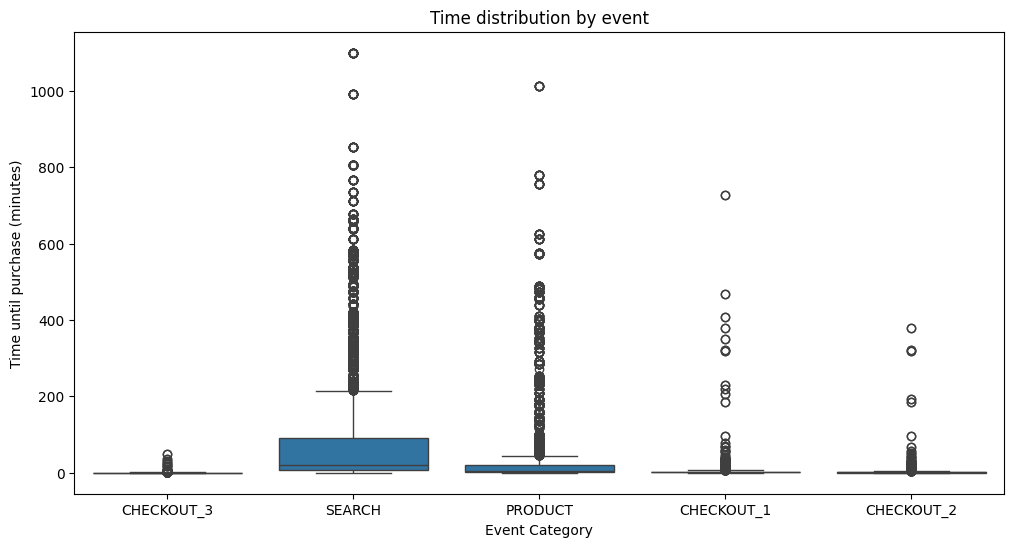

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

plt.figure(figsize=(12, 6))
sns.boxplot(data=result, x='event_name', y='time_diff')
plt.xlabel('Event Category')
plt.ylabel('Time until purchase (minutes)')
plt.title('Time distribution by event')
plt.show()

#### Log transform

In [16]:
result['log_time_diff'] = np.log1p(result['time_diff'])
result1['log_time_diff'] = np.log1p(result1['time_diff'])

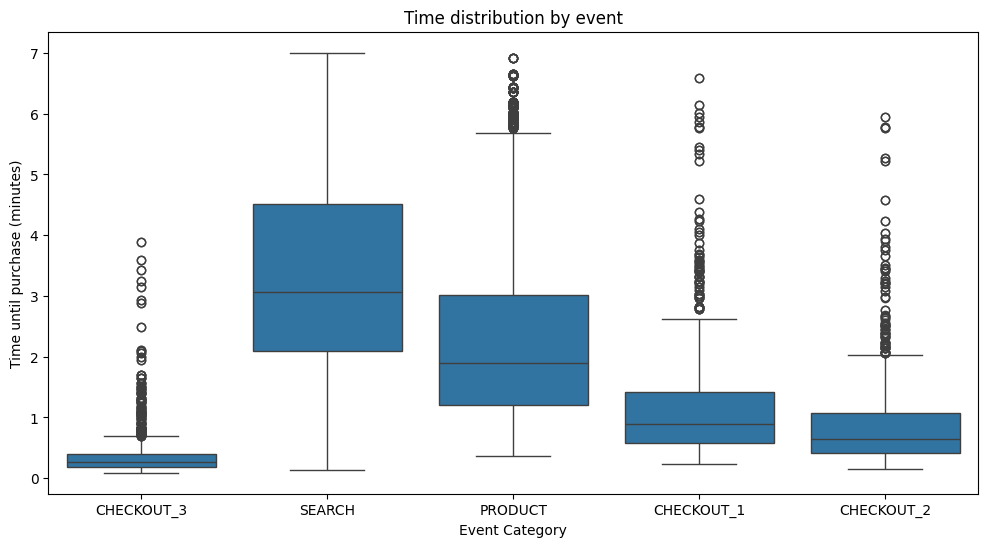

In [23]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=result, x='event_name', y='log_time_diff')
plt.xlabel('Event Category')
plt.ylabel('Time until purchase (minutes)')
plt.title('Time distribution by event')
plt.show()

Text(0.5, 1.0, 'QQ-Plot Time Diff')

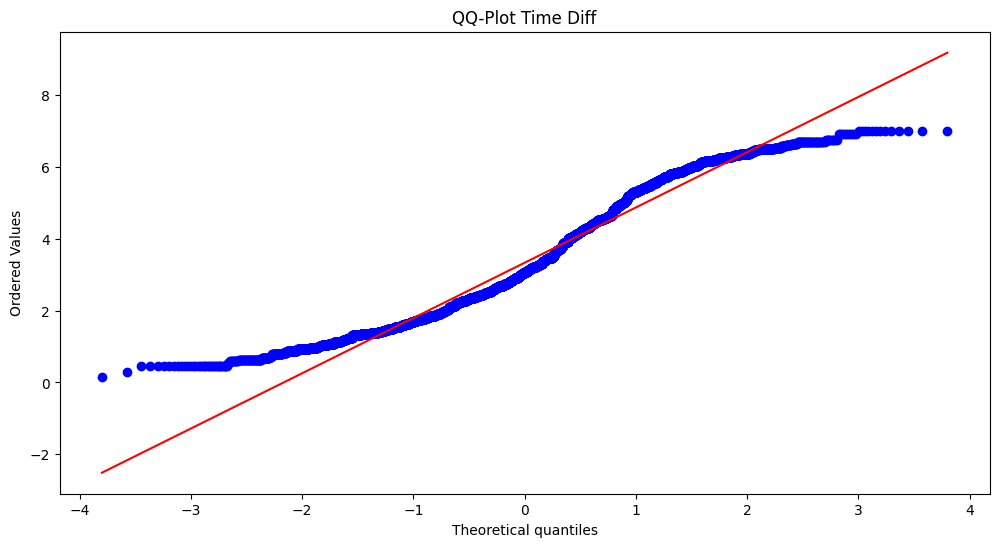

In [18]:
plt.figure(figsize=(12, 6))
stats.probplot(result[result["event_name"].isin(["SEARCH"])]['log_time_diff'], dist="norm", plot=plt)
plt.title('QQ-Plot Time Diff')

#### Remove Outliers

In [19]:
Q1_log = result.groupby(['event_name'])['log_time_diff'].quantile(0.25)
Q3_log = result.groupby(['event_name'])['log_time_diff'].quantile(0.75)
IQR_log = Q3_log - Q1_log

lower_bound_log = Q1_log - 1.5 * IQR_log
upper_bound_log = Q3_log + 1.5 * IQR_log

def remove_outliers_log(df, lower_bound_log, upper_bound_log):
    return df[(df['log_time_diff'] >= lower_bound_log[df['event_name']].values) & (df['log_time_diff'] <= upper_bound_log[df['event_name']].values)]

filtered_result_log = remove_outliers_log(result, lower_bound_log, upper_bound_log)


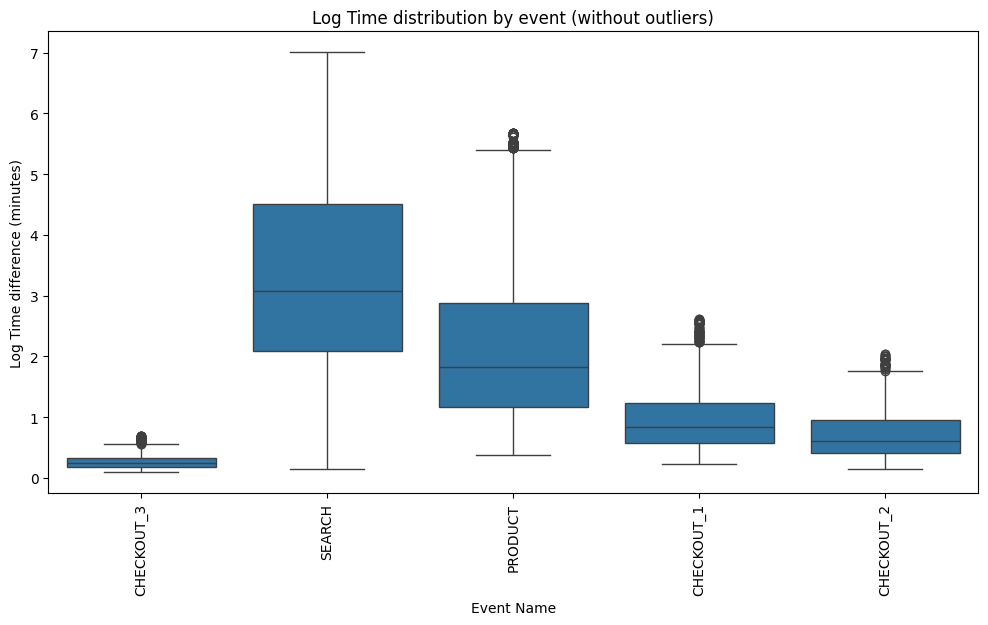

In [25]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=filtered_result_log, x='event_name', y='log_time_diff')
plt.xlabel('Event Name')
plt.ylabel('Log Time difference (minutes)')
plt.title('Log Time distribution by event (without outliers)')
plt.xticks(rotation=90)
plt.show()

#### Quantile selection (PRODUCT Event)

In [21]:
import numpy as np
from statsmodels.stats.proportion import proportions_ztest

np.random.seed(42)

def validate_threshold(row, thresholds):
    if pd.isnull(row['time_diff']):
        return False
    elif row["group"] == "threshold_1":
        return row['log_time_diff'] <= thresholds[0]
    else:
        return row['log_time_diff'] <= thresholds[1]
    
def quantile_selection(data, event_name):
    df = data[data["event_name"] == event_name].copy()
    quantiles_list = [0.75, 0.80, 0.85, 0.90, 0.95, 0.99]
    df['group'] = np.random.choice(['threshold_1', 'threshold_2'], size=len(df), p=[0.5, 0.5])

    print(event_name)
    for i in range(len(quantiles_list) - 1):
        thresholds = quantiles_list[i:i+2]
        quantiles = [
            df["log_time_diff"].quantile(thresholds[0]),
            df["log_time_diff"].quantile(thresholds[1])
        ]
        df["purchase"] = df.apply(validate_threshold, axis=1, thresholds=quantiles)
        time_selected = df[df["log_time_diff"] <= quantiles[1]]["time_diff"].max()
        
        success_2 = df[df['group'] == 'threshold_2']['purchase'].sum()
        n_2 = len(df[df['group'] == 'threshold_2'])
        success_1 = df[df['group'] == 'threshold_1']['purchase'].sum()
        n_1 = len(df[df['group'] == 'threshold_1'])
        count = np.array([success_2, success_1])
        nobs = np.array([n_2, n_1])
        stat, p_value_conversion = proportions_ztest(count, nobs, alternative='larger')
        print(f"H0 {thresholds[1]} <= {thresholds[0]}, P-value: {p_value_conversion:.4}, time: {time_selected:.10}")

    print("")


events = result1["event_name"].unique().tolist()

for e in events:
    quantile_selection(result1, e)

PRODUCT
H0 0.8 <= 0.75, P-value: 0.002254, time: 24.948
H0 0.85 <= 0.8, P-value: 0.001325, time: 43.13918333
H0 0.9 <= 0.85, P-value: 0.002049, time: 69.66485
H0 0.95 <= 0.9, P-value: 0.002912, time: 228.9528333
H0 0.99 <= 0.95, P-value: 0.01513, time: 487.3412833

SEARCH
H0 0.8 <= 0.75, P-value: 0.03955, time: 121.8416667
H0 0.85 <= 0.8, P-value: 0.05687, time: 193.8674167
H0 0.9 <= 0.85, P-value: 0.03823, time: 279.0100167
H0 0.95 <= 0.9, P-value: 0.03263, time: 441.7946667
H0 0.99 <= 0.95, P-value: 0.1707, time: 663.1099833

CHECKOUT_3
H0 0.8 <= 0.75, P-value: 0.02305, time: 0.5695666667
H0 0.85 <= 0.8, P-value: 0.04049, time: 0.7110333333
H0 0.9 <= 0.85, P-value: 0.07586, time: 0.9504666667
H0 0.95 <= 0.9, P-value: 0.03407, time: 1.826033333
H0 0.99 <= 0.95, P-value: 0.01607, time: 7.064716667

CHECKOUT_1
H0 0.8 <= 0.75, P-value: 0.02554, time: 3.78205
H0 0.85 <= 0.8, P-value: 0.03231, time: 5.36105
H0 0.9 <= 0.85, P-value: 0.03077, time: 7.981416667
H0 0.95 <= 0.9, P-value: 0.0288